<a href="https://colab.research.google.com/github/sonalshreya25/DeepLearning/blob/main/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import kagglehub
import wandb



# Checking for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting seed for repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensuring deterministic behavior for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False





Using device: cuda:0


In [40]:
wandb.init(project="autoencoder", entity="usf-alpha-neurons", config={
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 0.001
})

In [33]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset


# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)


df = pd.read_csv(f'{path}/creditcard.csv')

print("Dataset shape:", df.shape)
print(df.head())




Path to dataset files: /kaggle/input/creditcardfraud
Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.00


Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


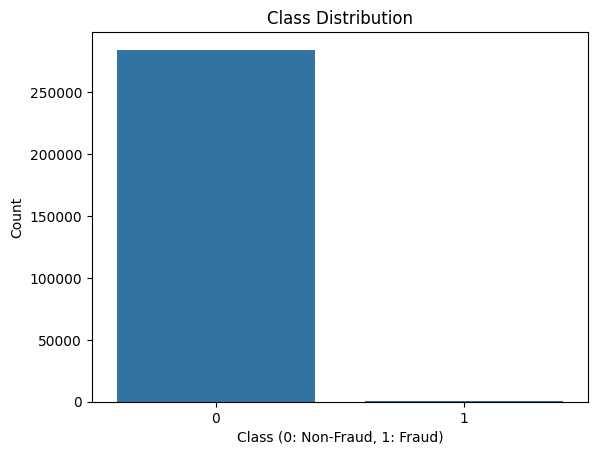


Descriptive statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+

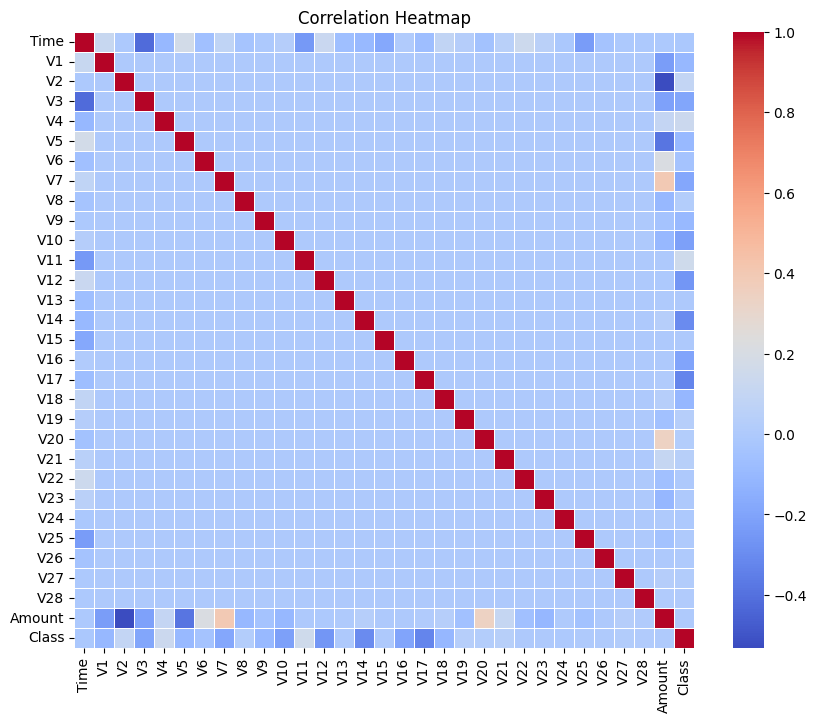

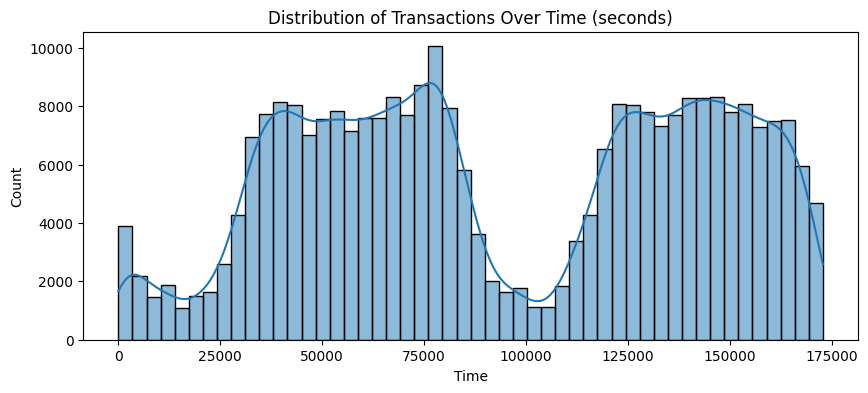

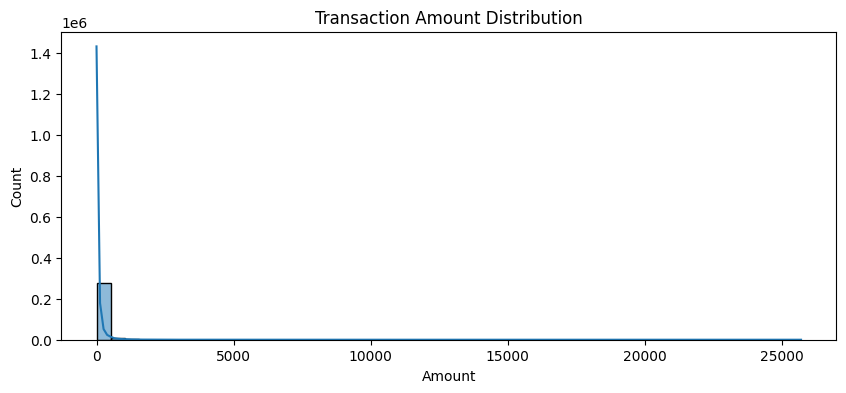

In [24]:
# Check for null values
print("\nMissing values:")
print(df.isnull().sum())

# Class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Describe statistics
print("\nDescriptive statistics:")
print(df.describe())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Time-based transaction distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title('Distribution of Transactions Over Time (seconds)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

# Amount distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()


<Axes: xlabel='Time', ylabel='Amount'>

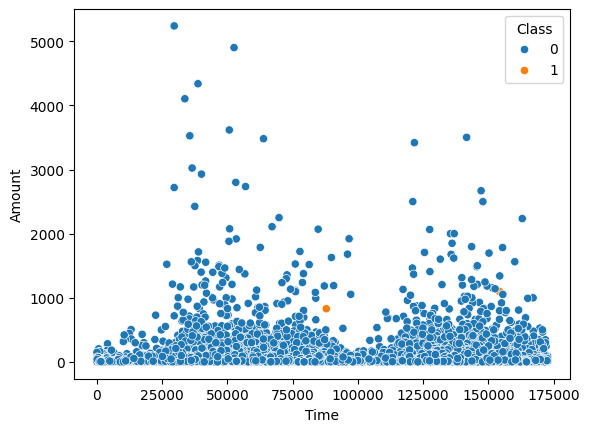

In [6]:
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df.sample(10000))

In [34]:
# ----------------------------
# Normalize data
# ----------------------------
features = df.drop(columns=['Class'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Get target values
y_np = df['Class'].values

# Select only non-fraud samples for training
non_fraud_indices = np.where(y_np == 0)[0]
fraud_indices = np.where(y_np == 1)[0]

X_non_fraud = features_scaled[non_fraud_indices]
y_non_fraud = y_np[non_fraud_indices]

X_fraud = features_scaled[fraud_indices]
y_fraud = y_np[fraud_indices]

# Split non-fraud data into train/test (No Stratified Split)
X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    X_non_fraud, y_non_fraud, test_size=0.2, random_state=42
)

# Combine test set: normal + fraud
X_test = np.concatenate((X_test_normal, X_fraud), axis=0)
y_test = np.concatenate((y_test_normal, y_fraud), axis=0)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [29]:
# Initialize model, loss function and optimizer
model = Autoencoder(input_size=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    wandb.log({"epoch": epoch+1, "loss": avg_loss})
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/20], Loss: 0.8553
Epoch [2/20], Loss: 0.8025
Epoch [3/20], Loss: 0.7830
Epoch [4/20], Loss: 0.7743
Epoch [5/20], Loss: 0.7591
Epoch [6/20], Loss: 0.7482
Epoch [7/20], Loss: 0.7423
Epoch [8/20], Loss: 0.7393
Epoch [9/20], Loss: 0.7373
Epoch [10/20], Loss: 0.7319
Epoch [11/20], Loss: 0.7273
Epoch [12/20], Loss: 0.7258
Epoch [13/20], Loss: 0.7244
Epoch [14/20], Loss: 0.7233
Epoch [15/20], Loss: 0.7225
Epoch [16/20], Loss: 0.7221
Epoch [17/20], Loss: 0.7214
Epoch [18/20], Loss: 0.7206
Epoch [19/20], Loss: 0.7191
Epoch [20/20], Loss: 0.7179


Threshold for anomaly detection: 3.5367
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     56863
         1.0       0.29      0.81      0.42       492

    accuracy                           0.98     57355
   macro avg       0.64      0.89      0.71     57355
weighted avg       0.99      0.98      0.99     57355



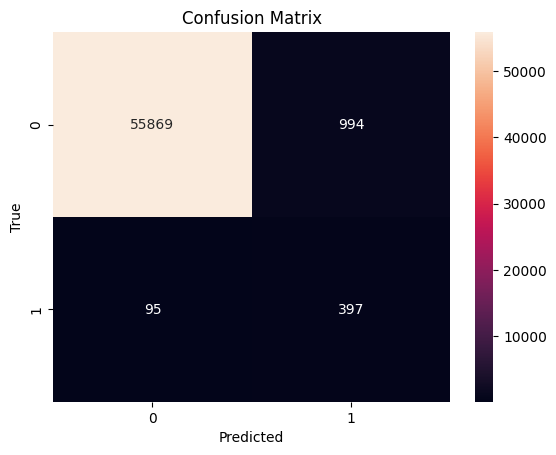

Accuracy: 0.9810
Precision: 0.2854
Recall: 0.8069
F1 Score: 0.4217
ROC AUC Score: 0.9526


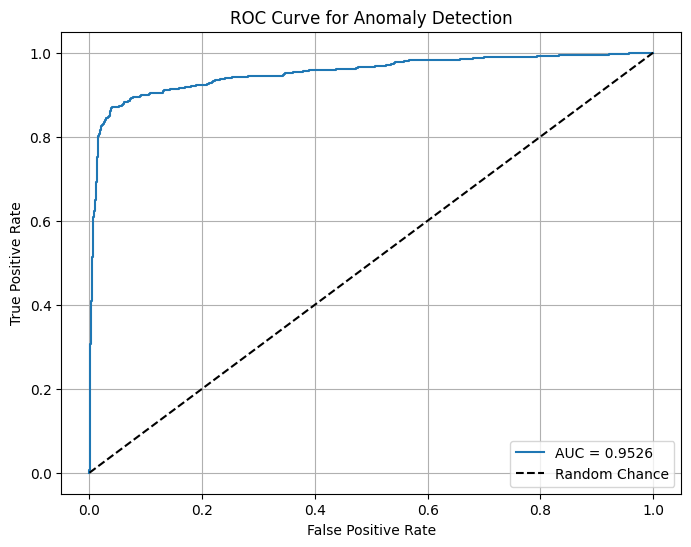

Model saved and logged as W&B artifact.


accuracy,▁
anomaly_threshold,▁
auc_score,▁
epoch,▁▁▂▂▂▃▃▄▄▄▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▅▄▃▃▃▂▂▂▂▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
precision,▁
recall,▁
accuracy,0.98101
anomaly_threshold,3.53673
auc_score,0.95262


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluation
model.eval()
losses = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)
        losses.append(loss.item())

threshold = np.mean(losses) + np.std(losses)
print(f'Threshold for anomaly detection: {threshold:.4f}')

# Generating predictions
y_pred = []
y_true = []
reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for batch_X, labels in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)

        sample_loss = torch.mean((batch_X - outputs) ** 2, dim=1)
        reconstruction_errors.extend(sample_loss.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for l in sample_loss:
            y_pred.append(1 if l.item() > threshold else 0)
        y_true.extend(labels.cpu().numpy())

# Evaluation Metrics
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute and log additional metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC and AUC
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
auc_score = roc_auc_score(true_labels, reconstruction_errors)
print(f"ROC AUC Score: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc_score": auc_score,
    "anomaly_threshold": threshold,
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=y_true,
        preds=y_pred,
        class_names=["Non-Fraud", "Fraud"]
    )
})


# Save model locally
model_path = "autoencoder_model.pth"
torch.save(model.state_dict(), model_path)

# Create and log W&B artifact
artifact = wandb.Artifact("autoencoder-fraud-model", type="model")
artifact.add_file(model_path)
wandb.log_artifact(artifact)
print("Model saved and logged as W&B artifact.")
wandb.finish()


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder_fc1 = nn.Linear(input_dim, 64)
        self.encoder_fc2 = nn.Linear(64, 32)

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder_fc1 = nn.Linear(latent_dim, 32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_out = nn.Linear(64, input_dim)

    def encode(self, x):
        h = F.relu(self.encoder_fc1(x))
        h = F.relu(self.encoder_fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z

    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        h = F.relu(self.decoder_fc2(h))
        return self.decoder_out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar


In [36]:
def vae_loss(reconstructed, original, mu, logvar):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / original.size(0)
    return recon_loss + kl_div


In [38]:
model = VAE(input_dim=X_train.shape[1], latent_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)  # Fix: unpack batch
        optimizer.zero_grad()
        recon, mu, logvar = model(inputs)
        loss = vae_loss(recon, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.5f}")

    # Log to W&B
    wandb.log({"epoch": epoch+1, "vae_train_loss": avg_loss})


Epoch [1/20], Loss: 0.96404
Epoch [2/20], Loss: 0.96247
Epoch [3/20], Loss: 0.96241
Epoch [4/20], Loss: 0.96242
Epoch [5/20], Loss: 0.96241
Epoch [6/20], Loss: 0.96241
Epoch [7/20], Loss: 0.96240
Epoch [8/20], Loss: 0.96241
Epoch [9/20], Loss: 0.96240
Epoch [10/20], Loss: 0.96240
Epoch [11/20], Loss: 0.96241
Epoch [12/20], Loss: 0.96240
Epoch [13/20], Loss: 0.96242
Epoch [14/20], Loss: 0.96242
Epoch [15/20], Loss: 0.96240
Epoch [16/20], Loss: 0.96241
Epoch [17/20], Loss: 0.96241
Epoch [18/20], Loss: 0.96241
Epoch [19/20], Loss: 0.96240
Epoch [20/20], Loss: 0.96241


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56863
           1       0.13      0.88      0.23       492

    accuracy                           0.95     57355
   macro avg       0.57      0.91      0.60     57355
weighted avg       0.99      0.95      0.97     57355



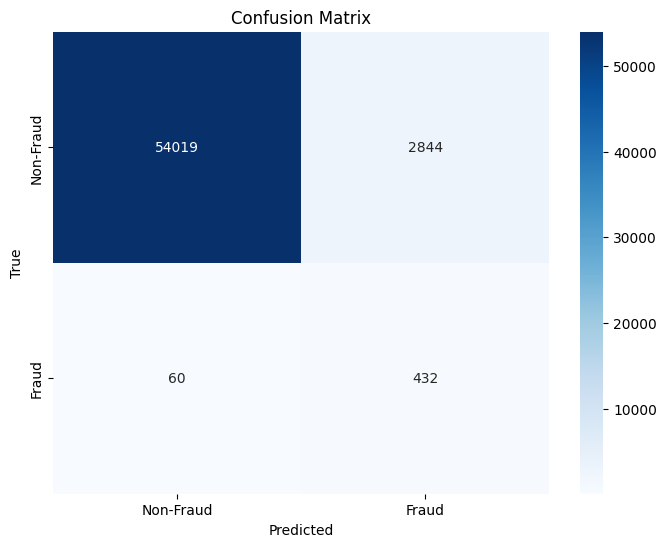

accuracy,▁
anomaly_threshold,▁
auc_score,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
precision,▁
recall,▁
vae_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94937
anomaly_threshold,1.90659
auc_score,0.95251


In [39]:
# Assuming model, train_loader, and test_loader are already defined
model.eval()

with torch.no_grad():
    recon, _, _ = model(torch.tensor(X_test).float().to(device))
    recon_error = torch.mean((recon - torch.tensor(X_test).float().to(device))**2, dim=1)
    recon_error = recon_error.cpu().numpy()

# Setting a threshold for anomaly detection based on reconstruction error of non-fraud samples
threshold = np.percentile(recon_error[y_test == 0], 90)
y_pred = (recon_error > threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, recon_error)

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Log metrics to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc_score": auc,
    "anomaly_threshold": threshold
})

# Save the model as an artifact in W&B
artifact = wandb.Artifact("vae_model", type="model")
torch.save(model.state_dict(), "vae_model.pth")
artifact.add_file("vae_model.pth")
wandb.log_artifact(artifact)

# Finish W&B run
wandb.finish()
